# Model Building

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
import statsmodels.api as sm

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc, average_precision_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

drive_dir = "/content/drive/My Drive"
mount_dir = os.path.join(drive_dir, "Colab Notebooks")
results_dir = os.path.join(mount_dir, "results_folder")

Mounted at /content/drive


## 1. Data Preproccesing

### 1.1 Radiomic Features

In [ ]:
# load data set
radiomic_feats = pd.read_csv(os.path.join(results_dir, "RadiomicFeatures.csv"))
radiomic_feats.head()

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance
0,0.527583,0.513377,57.283694,111.582079,114.212590,115.152790,73.284082,122.643745,237540.783691,58.868845,...,17.019354,0.011378,489.785185,0.403115,0.658978,136.257830,0.007516,6.080010,0.180107,3255.880190
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.521267,0.446565,45.221860,101.266101,113.592903,100.020486,60.776486,113.771650,164111.006592,52.786691,...,39.427170,0.014237,1231.206019,0.382006,0.641698,130.008726,0.007626,6.319431,0.143800,10372.099039
3,0.565475,0.449311,46.427784,103.331131,113.553247,112.623081,68.007353,115.767666,194060.038535,58.431183,...,26.608202,0.020693,1239.888344,0.433983,0.685239,89.661381,0.013659,5.961805,0.161058,5504.858331
4,0.485448,0.407476,42.413620,104.088690,111.060812,106.570473,58.235949,111.219413,154694.140625,50.529691,...,13.131031,0.015890,1038.289971,0.377286,0.636561,129.422304,0.008716,6.460849,0.150145,4201.871850


In [ ]:
# create id vector
id_less10 = np.array((['LIVER_00' + str(n) for n in range(1,10)]))
id_geq10 = np.array((['LIVER_0' + str(n) for n in range(10,41)]))
ids = np.hstack((id_less10, id_geq10))
radiomic_feats['id'] = ids.tolist()

# add outcome variable to df
HCC = np.concatenate((np.ones(20), np.zeros(20)), axis=0)
radiomic_feats['HCC'] = HCC.tolist()

In [ ]:
# remove rows with all 0s
radiomic_feats = radiomic_feats[radiomic_feats.drop(['id','HCC'], axis=1).ne(0).any(axis=1)].reset_index(drop=True)
radiomic_feats.shape # 6 rows with all missings

(34, 74)

In [ ]:
# remove constant features
constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(radiomic_feats.drop(['id','HCC'], axis=1))
constant_columns = [column for column in radiomic_feats.drop(['id','HCC'], axis=1).columns
                    if column not in radiomic_feats.drop(['id','HCC'], axis=1).columns[constant_filter.get_support()]]
radiomic_feats.drop(labels=constant_columns, axis=1, inplace=True)
radiomic_feats.shape # no constant features 

(34, 74)

In [ ]:
# remove quasi constant features
qconstant_filter = VarianceThreshold(threshold=0.001)
qconstant_filter.fit(radiomic_feats.drop(['id','HCC'], axis=1))
qconstant_columns = [column for column in radiomic_feats.drop(['id','HCC'], axis=1).columns
                     if column not in radiomic_feats.drop(['id','HCC'], axis=1).columns[qconstant_filter.get_support()]]
radiomic_feats.drop(labels=qconstant_columns, axis=1, inplace=True)
radiomic_feats.shape # 8 quasi-constant features

(34, 66)

In [ ]:
# get column names
radiomic_col = list(radiomic_feats.drop(['id','HCC'], axis=1).columns)

# z-score standardize predictors
scaler = StandardScaler()
radiomic_feats_std = scaler.fit_transform(radiomic_feats.drop(['id','HCC'], axis=1))
radiomic_feats_std = pd.DataFrame(radiomic_feats_std, columns=radiomic_col)

# concatenate both dfs
radiomic_feats = pd.concat([radiomic_feats.loc[:,['id','HCC']].reset_index(drop=True), radiomic_feats_std], axis=1)

### 1.2 Deep Features

In [ ]:
# load data set
deep_feats = pd.read_csv(os.path.join(results_dir, "DeepFeaturesNew.csv"))
deep_feats.head()

,id,HCC,var1,var2,var3,var4,var5,var6,var7,var8,...,var119,var120,var121,var122,var123,var124,var125,var126,var127,var128
0,LIVER_023,0,-0.202069,-0.088254,-0.257660,-0.077059,0.215050,-0.167437,0.140313,0.088868,...,-0.337239,0.179754,-0.075700,0.287734,-0.091015,-0.272713,-0.090688,0.186573,0.134264,0.078066
1,LIVER_039,0,-0.176814,-0.059283,-0.261327,-0.082698,0.048886,-0.001115,0.035702,0.119655,...,-0.183480,0.332741,-0.014124,0.290838,-0.033038,-0.095075,-0.019054,-0.008752,-0.020521,-0.027283
2,LIVER_028,0,0.378205,-0.237747,-0.137053,-0.093801,0.515436,0.073770,-0.398368,0.171456,...,-0.159522,0.967786,-0.021786,0.427982,-0.292361,0.367582,0.179641,-0.023854,-0.038469,0.641371
3,LIVER_019,1,0.706900,-0.379466,-0.093411,-0.128402,0.670975,0.208453,-0.736853,0.319404,...,-0.052715,1.555141,0.096538,0.550754,-0.380608,0.847317,0.378209,-0.217176,-0.256849,0.978573
4,LIVER_006,1,-0.161161,-0.052261,-0.263995,-0.086058,-0.011500,0.039052,0.001275,0.129955,...,-0.149543,0.408186,0.012220,0.285333,-0.026853,-0.051228,0.000157,-0.065999,-0.062883,-0.082519


In [ ]:
# remove rows with all 0s
deep_feats = deep_feats[deep_feats.drop(['id','HCC'], axis=1).ne(0).any(axis=1)].reset_index(drop=True)
deep_feats.shape # No rows with all missings

(40, 130)

In [ ]:
# remove constant features
constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(deep_feats.drop(['id','HCC'], axis=1))
constant_columns = [column for column in deep_feats.drop(['id','HCC'], axis=1).columns
                    if column not in deep_feats.drop(['id','HCC'], axis=1).columns[constant_filter.get_support()]]
deep_feats.drop(labels=constant_columns, axis=1, inplace=True)
deep_feats.shape # no constant features 

(40, 130)

In [ ]:
# remove quasi-constant features
constant_filter = VarianceThreshold(threshold=0.001)
constant_filter.fit(deep_feats.drop(['id','HCC'], axis=1))
constant_columns = [column for column in deep_feats.drop(['id','HCC'], axis=1).columns
                    if column not in deep_feats.drop(['id','HCC'], axis=1).columns[constant_filter.get_support()]]
deep_feats.drop(labels=constant_columns, axis=1, inplace=True)
deep_feats.shape # 1 quasi-constant feature

(40, 129)

In [ ]:
# get column names
deep_col = list(deep_feats.drop(['id','HCC'], axis=1).columns)

# z-score standardize predictors
scaler = StandardScaler()
deep_feats_std = scaler.fit_transform(deep_feats.drop(['id','HCC'], axis=1))
deep_feats_std = pd.DataFrame(deep_feats_std, columns=deep_col)

# concatenate both dfs
deep_feats = pd.concat([deep_feats.loc[:,['id','HCC']].reset_index(drop=True), deep_feats_std], axis=1)

In [ ]:
# compute correlation between deep and handcrafted features
combined_feats = pd.concat([deep_feats.drop(['id','HCC'], axis=1), radiomic_feats.drop(['id','HCC'], axis=1)], axis=1, keys=['deep', 'rad'])
corr_mtx = combined_feats.corr().loc['rad', 'deep']

In [ ]:
# drop all features with r < 0.5 with handcrafted features
keep = list()

for row in range(len(corr_mtx)):
  for col in range(len(corr_mtx.columns)):
    if(abs(corr_mtx.iloc[row, col]) >= 0.5):
      keep.append(col)

keep_set = list(set(keep))
keepcols_names = list(deep_feats.drop(['id','HCC'], axis=1).columns[[item for item in keep_set]])

In [ ]:
# drop non-correlated features
corr_deep_feats = deep_feats[keepcols_names]
corr_deep_feats = pd.concat([deep_feats.loc[:,['id','HCC']].reset_index(drop=True), corr_deep_feats], axis=1)
corr_deep_feats.shape # 38 explainable deep features

(40, 106)

## 2. Model Building

### 2.1 Hyperparameter Tuning and Bootstrapping of Performance Metrics 

In [ ]:
# create index
index = deep_feats['id'].iloc[-8:]

# create list of data frames 
list_of_datasets = [radiomic_feats, corr_deep_feats]

# define hyperparameters
param = {'C':np.logspace(-3,3,7), 'penalty':['l1'], 'solver':['liblinear']}

# define range to be interpolated to
fpr_mean = np.linspace(0, 1, 1000)
recall_mean = np.linspace(0, 1, 1000)

# create storage
metrics = ['acc', 'auroc', 'precision', 'recall', 'fscore', 'auc_prc',
           'interp_tprs', 'tpr_mean', 'tpr_std', 'tpr_upper', 'tpr_lower',
           'interp_prec', 'prec_mean', 'prec_std', 'prec_upper', 'prec_lower']
results = {
    0: {m:[] for m in metrics},
    1: {m:[] for m in metrics},
}

In [ ]:
# loop over both datasets
for dataset in list_of_datasets:

  if len(dataset) < 40:
    counter = 0
  else:
    counter = 1

  # divide dataset in 80%:20% split
  train_X = dataset[~dataset['id'].isin(index)].drop(['id','HCC'], axis=1)
  test_X = dataset[dataset['id'].isin(index)].drop(['id','HCC'], axis=1)
  train_y = dataset[~dataset['id'].isin(index)]['HCC']
  test_y = dataset[dataset['id'].isin(index)]['HCC']

  # fit logistic regression model
  model = LogisticRegression(random_state=123)
  # obtain tuned hyperparameters using 3-fold cv
  model_cv = GridSearchCV(model, param, cv=3, refit=True, scoring='accuracy')
  model_cv = model_cv.fit(train_X, train_y)
  # print optimizied hyperparameter settings
  print("best parameters:", model_cv.best_params_)

  # obtain bootstrapped performance metric estimates
  n_iterations = 1000
  for iter in range(n_iterations):
    
    # resample test data with replacement
    boot_X, boot_y = resample(test_X, test_y, replace=True, n_samples=16, random_state=iter)

    # make predictions
    pred = model_cv.predict(boot_X)
    # compute accuracy
    acc = model_cv.score(boot_X, boot_y)
    # compute predicted probabilities
    pred_prob = model_cv.predict_proba(boot_X)

    # compute false-positive and true-positive rate
    fpr, tpr, _ = roc_curve(boot_y, pred_prob[:,1])
    interp_tpr = np.interp(fpr_mean, fpr, tpr)
    interp_tpr[0] = 0.0
    # compute area under receiving operator curve
    auroc = roc_auc_score(boot_y, pred_prob[:,1])

    # compute precision and recall
    precisionr, recallr, _ = precision_recall_curve(boot_y, pred_prob[:,1])
    reversed_recall = np.fliplr([recallr])[0]
    reversed_precision = np.fliplr([precisionr])[0]
    interp_prec = np.interp(recall_mean, reversed_recall, reversed_precision)
    interp_prec[0] = 1.0
    # compute area under precision recall curve
    auc_prc = auc(recallr, precisionr)

    # compute other performance metrics
    precision = precision_score(boot_y, pred)
    recall = recall_score(boot_y, pred)
    fscore = f1_score(boot_y, pred)

    # store performance metrics
    results[counter]['acc'].append(acc)
    results[counter]['auroc'].append(auroc)
    results[counter]['interp_tprs'].append(interp_tpr)
    results[counter]['precision'].append(precision)
    results[counter]['recall'].append(recall)
    results[counter]['interp_prec'].append(interp_prec)
    results[counter]['fscore'].append(fscore)
    results[counter]['auc_prc'].append(auc_prc)

  # compute mean, std, and upper/lower bound of true positive rate
  tpr_mean = np.mean(results[counter]['interp_tprs'], axis=0)
  tpr_mean[-1] = 1.0
  tpr_std = 2*np.std(results[counter]['interp_tprs'], axis=0)
  tpr_upper = np.clip(tpr_mean+tpr_std, 0, 1)
  tpr_lower = tpr_mean-tpr_std

  # compute mean, std, and upper/lower bound of precision
  prec_mean = np.mean(results[counter]['interp_prec'], axis=0)
  prec_std = 2*np.std(results[counter]['interp_prec'], axis=0)
  prec_upper = np.clip(prec_mean+prec_std, 0, 1)
  prec_lower = prec_mean-prec_std

  # store computed statistics
  results[counter]['tpr_mean'].append(tpr_mean)
  results[counter]['tpr_std'].append(tpr_std)
  results[counter]['tpr_upper'].append(tpr_upper)
  results[counter]['tpr_lower'].append(tpr_lower)

  results[counter]['prec_mean'].append(prec_mean)
  results[counter]['prec_std'].append(prec_std)
  results[counter]['prec_upper'].append(prec_upper)
  results[counter]['prec_lower'].append(prec_lower)

best parameters: {'C': 1000.0, 'penalty': 'l1', 'solver': 'liblinear'}


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

best parameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}


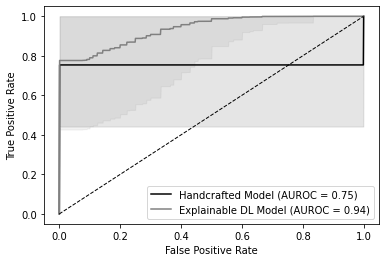

In [ ]:
# plot receiving operater curves
plt.plot(fpr_mean, np.squeeze(results[0]['tpr_mean'], axis=0),
         label="Handcrafted Model (AUROC = %0.2f)" % np.mean(results[0]['auroc']),
         color='black')
plt.fill_between(fpr_mean, np.squeeze(results[0]['tpr_lower'], axis=0), 
                 np.squeeze(results[0]['tpr_upper'], axis=0), color='black', alpha=0.1)
plt.plot(fpr_mean, np.squeeze(results[1]['tpr_mean'], axis=0),
         label="Explainable DL Model (AUROC = %0.2f)" % np.mean(results[1]['auroc']),
         color='grey')
plt.fill_between(fpr_mean, np.squeeze(results[1]['tpr_lower'], axis=0), 
                 np.squeeze(results[1]['tpr_upper'], axis=0), color='grey', alpha=0.1)
plt.plot([0, 1], [0, 1], color="black", lw=1, linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

plt.savefig(os.path.join(data_dir, 'auroc.png'), dpi=300)

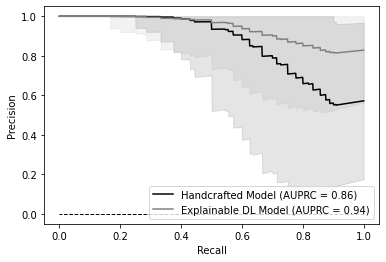

In [ ]:
# plot precision recall curves
plt.plot(recall_mean, np.squeeze(results[0]['prec_mean'], axis=0),
         label="Handcrafted Model (AUPRC = %0.2f)" % np.mean(results[0]['auc_prc']),
         color='black')
plt.fill_between(recall_mean, np.squeeze(results[0]['prec_lower'], axis=0), 
                 np.squeeze(results[0]['prec_upper'], axis=0), color='black', alpha=0.1)
plt.plot(recall_mean, np.squeeze(results[1]['prec_mean'], axis=0),
         label="Explainable DL Model (AUPRC = %0.2f)" % np.mean(results[1]['auc_prc']),
         color='grey')
plt.fill_between(recall_mean, np.squeeze(results[1]['prec_lower'], axis=0), 
                 np.squeeze(results[1]['prec_upper'], axis=0), color='grey', alpha=0.1)
plt.plot([1, 0], [0, 0], color="black", lw=1, linestyle="--")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower right")

plt.savefig(os.path.join(data_dir, 'auprc.png'), dpi=300)

In [ ]:
def get_confidence_interval(boot_estimates):
  mean = np.mean(boot_estimates, axis=0)
  std = 2*np.std(boot_estimates, axis=0)
  upper = np.clip(mean+std, 0, 1)
  lower = mean-std

  return mean, lower, upper

In [ ]:
get_confidence_interval(results[0]['acc']) # accuracy = 0.752 [0.537, 0.968]
get_confidence_interval(results[1]['acc']) # accuracy = 0.748 [0.525, 0.972]
get_confidence_interval(results[0]['precision']) # precision = 0.992 [0.814, 1.000]
get_confidence_interval(results[1]['precision']) # precision = 0.748 [0.427, 1.000]
get_confidence_interval(results[0]['recall']) # recall = 0.509 [0.146, 0.871]
get_confidence_interval(results[1]['recall']) # recall = 0.747 [0.422, 1.000]
get_confidence_interval(results[0]['fscore']) # F1-score = 0.654 [0.317, 0.992]
get_confidence_interval(results[1]['fscore']) # F1-score = 0.734 [0.466, 1.000]

(0.7341384574113313, 0.4663404647013065, 1.0)

### 2.2 Derivation of Regression Coefficients

In [ ]:
# divide dataset in 80%:20% split
train_X = corr_deep_feats[~corr_deep_feats['id'].isin(index)].drop(['id','HCC'], axis=1)
test_X = corr_deep_feats[corr_deep_feats['id'].isin(index)].drop(['id','HCC'], axis=1)
train_y = corr_deep_feats[~corr_deep_feats['id'].isin(index)]['HCC']
test_y = corr_deep_feats[corr_deep_feats['id'].isin(index)]['HCC']

# get coefficients 
logit_mod = sm.Logit(train_y, train_X)
logit_res = logit_mod.fit_regularized(alpha=1)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.30872103065595147
            Iterations: 80
            Function evaluations: 83
            Gradient evaluations: 80


In [ ]:
# print summary
logit_res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.712     
Dependent Variable: HCC              AIC:              18.7549   
Date:               2023-01-07 13:50 BIC:              23.1521   
No. Observations:   32               Log-Likelihood:   -6.3774   
Df Model:           2                LL-Null:          -22.181   
Df Residuals:       29               LLR p-value:      1.3700e-07
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     80.0000                                      
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
var1       0.0000        nan       nan      nan       nan       nan
var2       0.0000        nan       nan      nan       nan       nan
var3       0.0000        nan       nan      nan       nan       nan
var5       0.0000        nan       nan      nan       nan       nan
var7       0.0000        nan       nan      nan       nan       nan
var9       0.0000        nan       nan      nan       nan       nan
var10      0.0000        nan       nan      nan       nan       nan
var11      0.0000        nan       nan      nan       nan       nan
var12     -0.3247     0.8503   -0.3818   0.7026   -1.9912    1.3419
var13      0.0000        nan       nan      nan       nan       nan
var14      0.0000        nan       nan      nan       nan       nan
var15      0.0000        nan       nan      nan       nan       nan
var16      0.0000        nan       nan      nan       nan       nan
var17      0.0000        nan       nan      nan       nan       nan
var18      0.0000        nan       nan      nan       nan       nan
var19      0.0000        nan       nan      nan       nan       nan
var22      0.0000        nan       nan      nan       nan       nan
var26      0.0000        nan       nan      nan       nan       nan
var27      0.0000        nan       nan      nan       nan       nan
var28      0.0000        nan       nan      nan       nan       nan
var29      0.0000        nan       nan      nan       nan       nan
var30      0.0000        nan       nan      nan       nan       nan
var31      0.0000        nan       nan      nan       nan       nan
var32     -1.0814     0.6035   -1.7921   0.0731   -2.2642    0.1013
var33      0.0000        nan       nan      nan       nan       nan
var34      0.0000        nan       nan      nan       nan       nan
var35      0.0000        nan       nan      nan       nan       nan
var36      0.0000        nan       nan      nan       nan       nan
var38      0.0000        nan       nan      nan       nan       nan
var39      0.0000        nan       nan      nan       nan       nan
var40      0.0000        nan       nan      nan       nan       nan
var42      0.0000        nan       nan      nan       nan       nan
var43      0.0000        nan       nan      nan       nan       nan
var44      0.0000        nan       nan      nan       nan       nan
var45      0.0000        nan       nan      nan       nan       nan
var46      0.0000        nan       nan      nan       nan       nan
var47      0.0000        nan       nan      nan       nan       nan
var48      0.0000        nan       nan      nan       nan       nan
var49      0.0000        nan       nan      nan       nan       nan
var50      0.0000        nan       nan      nan       nan       nan
var51      0.0000        nan       nan      nan       nan       nan
var52      0.0000        nan       nan      nan       nan       nan
var53      0.0000        nan       nan      nan       nan       nan
var54      0.0000        nan       nan      nan       nan       nan
var56      0.0000        nan       nan      nan       nan       nan
var58      0.0000        nan       nan      nan      

In [ ]:
import math
math.exp(-0.3247) # 0.723
math.exp(-1.0814) # 0.339
math.exp(-2.0955) # 0.123

0.12300872391335757

In [ ]:
pd.set_option('display.max_rows', None)
corr_mtx.loc[:,['var12','var32','var80']]

# var12: 90Percentile, Mean, Median, RootMeanSquared
# var32: SizeZoneNonUniformity(glszm)
# var80: 10Percentile, 90Percentile, Maximum, MeanAbsoluteDeviation, Median, Range,
#        RobustMeanAbsoluteDeviation, RootMeanSquared, TotalEnergy, Variance